# Netflix Movie Recommendation System

## Business Problem
Netflix's main goal is to best suggest a movie to a User . The goal of this project is to predict if a User U will like a Movie M by predicting the rating of the Movie and suggest the user U that particular movie.


<p>Credits: https://www.netflixprize.com/rules.html</p>

Link to data:
https://www.kaggle.com/netflix-inc/netflix-prize-data




### Machine Learning Problem 
1.	Predict the rating that a user would give to a movie<br>
2.	Minimize the difference between predicted and actual rating (RMSE and MAPE).
#### Data provided has 17770 unique movie IDs, 480189 unique user IDs and Movie ratings ranging from 1-5


<p style = "font-size: 22px"><b>Example Data Point</b></p>
<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
124105,4,2004-08-05
1248029,3,2004-04-22
1842128,4,2004-05-09
2238063,3,2005-05-11
1503895,4,2005-05-19
2207774,5,2005-06-06
2590061,3,2004-08-12
2442,3,2004-04-14
543865,4,2004-05-28
1209119,4,2004-03-23
804919,4,2004-06-10
1086807,3,2004-12-28
1711859,4,2005-05-08
372233,5,2005-11-23
1080361,3,2005-03-28
1245640,3,2005-12-19
558634,4,2004-12-14
2165002,4,2004-04-06
1181550,3,2004-02-01
1227322,4,2004-02-06
427928,4,2004-02-26
814701,5,2005-09-29
808731,4,2005-10-31
662870,5,2005-08-24
337541,5,2005-03-23
786312,3,2004-11-16
1133214,4,2004-03-07
1537427,4,2004-03-29
1209954,5,2005-05-09
2381599,3,2005-09-12
525356,2,2004-07-11
1910569,4,2004-04-12
2263586,4,2004-08-20
2421815,2,2004-02-26
1009622,1,2005-01-19
1481961,2,2005-05-24
401047,4,2005-06-03
2179073,3,2004-08-29
1434636,3,2004-05-01
93986,5,2005-10-06
1308744,5,2005-10-29
2647871,4,2005-12-30
1905581,5,2005-08-16
2508819,3,2004-05-18
1578279,1,2005-05-19
1159695,4,2005-02-15
2588432,3,2005-03-31
2423091,3,2005-09-12
470232,4,2004-04-08
2148699,2,2004-06-05
1342007,3,2004-07-16
466135,4,2004-07-13
2472440,3,2005-08-13
1283744,3,2004-04-17
1927580,4,2004-11-08
716874,5,2005-05-06
4326,4,2005-10-29
</pre>

### We consider this to be both Regression and Recommendation Problem


<p><b>Performance metric</b></p>
1. Mean Absolute Percentage Error
2. Root Mean Square Error


<p><b>Machine Learning Objective and Constraints</b></p>
1. Try to Minimize RMSE
2. Provide some form of interpretability

In [1]:
#importing all necessary libraries
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

### Data Pre-processing

In [3]:
if not os.path.isfile("./Data/NetflixRatings.csv"):
    Start_Time=datetime.now()
    data=open("./Data/NetflixRatings.csv", mode="w")
    files=['./Data/combined_data_2.txt', './Data/combined_data_4.txt']
    for file in files:
        print("Reading from file:",str(file)) 
        with open(file) as f:
            for line in f:
                line= line.strip()
                if line.endswith(":"):
                    Movie_ID=line.replace(":","")
                else:
                    row=[]
                    row=[x for x in line.split(",")]
                    row.insert(0,Movie_ID)
                    data.write(",".join(row))
                    data.write("\n")
        print(str(file),"completed")
    data.close()
    print("Time taken for processing the data:", datetime.now()-Start_Time)

In [4]:
# creating data frame from our output csv file.
if not os.path.isfile("./Data/NetflixData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("./Data/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = ",datetime.now() - startTime)

In [5]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("./Data/NetflixData.pkl"):
    Final_Data.to_pickle("./Data/NetflixData.pkl")
else:
    Final_Data = pd.read_pickle("./Data/NetflixData.pkl")

In [6]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
49557332,17064,510180,2,1999-11-11
46370047,16465,510180,3,1999-11-11
22463125,8357,510180,4,1999-11-11
35237815,14660,510180,2,1999-11-11
21262258,8079,510180,2,1999-11-11


In [7]:
Final_Data["Ratings"].head()

49557332    2
46370047    3
22463125    4
35237815    2
21262258    2
Name: Ratings, dtype: int64

In [8]:
Final_Data.describe()["Ratings"]

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

### Checking for Null Values  

In [9]:
print("Number of null values:", Final_Data.isnull().sum())

Number of null values: MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


### Removing Duplicates

In [10]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = ",duplicates.sum())


Number of duplicate rows =  0


### Details of Data

In [11]:
print("Total Data:")
print("Total number of movie ratings = ",len(Final_Data["Ratings"]))
print("Number of unique users = ",len(np.unique(Final_Data["CustID"])))
print("Number of unique movies = ",len(np.unique(Final_Data["MovieID"])))

Total Data:
Total number of movie ratings =  53825114
Number of unique users =  478723
Number of unique movies =  9114


# Splitting data into Training and Testing set :

In [12]:

if not os.path.isfile("./Data/Train_Data.pkl"): 
    Train_Data , Test_Data = train_test_split(Final_Data, test_size=0.25, random_state=0)
    Train_Data.to_pickle("./Data/Train_Data.pkl")
    Train_Data = pd.read_pickle("./Data/Train_Data.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("./Data/Train_Data.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
    
if not os.path.isfile("./Data/Test_Data.pkl"): 
    Train_Data , Test_Data = train_test_split(Final_Data, test_size=0.25, random_state=0)
    Test_Data.to_pickle("./Data/Test_Data.pkl")
    Test_Data = pd.read_pickle("./Data/Test_Data.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("./Data/Test_Data.pkl")
    Test_Data.reset_index(drop = True, inplace = True)


### Basic Statistics in Train data

In [13]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,5191,535765,2,2001-11-06
1,15129,533017,4,2004-12-20
2,6034,1178153,3,2005-01-31
3,14381,2083028,5,2004-10-26
4,14734,636881,4,2005-01-26


In [14]:
Train_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40368835 entries, 0 to 40368834
Data columns (total 4 columns):
MovieID    int64
CustID     int64
Ratings    int64
Date       datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 GB


In [15]:
Train_Data.describe()

,MovieID,CustID,Ratings
count,4.036884e+07,4.036884e+07,4.036884e+07
mean,1.113501e+04,1.322450e+06,3.606089e+00
std,4.577033e+03,7.645467e+05,1.082292e+00
min,4.500000e+03,6.000000e+00,1.000000e+00
25%,6.692000e+03,6.612350e+05,3.000000e+00
50%,9.205000e+03,1.318976e+06,4.000000e+00
75%,1.545000e+04,1.984378e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


### Basic Statistics in Test data

In [16]:
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,17149,1880385,3,2004-06-14
1,14432,1611512,1,2005-05-17
2,14928,2223245,4,2005-01-20
3,8159,2427937,5,2004-07-26
4,14745,349407,1,2002-06-28


In [17]:
Test_Data.describe()

,MovieID,CustID,Ratings
count,1.345628e+07,1.345628e+07,1.345628e+07
mean,1.113469e+04,1.322712e+06,3.605966e+00
std,4.577131e+03,7.644427e+05,1.082430e+00
min,4.500000e+03,6.000000e+00,1.000000e+00
25%,6.692000e+03,6.614590e+05,3.000000e+00
50%,9.205000e+03,1.319562e+06,4.000000e+00
75%,1.545000e+04,1.984602e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


## 2. Exploratory Data Analysis on Train Data

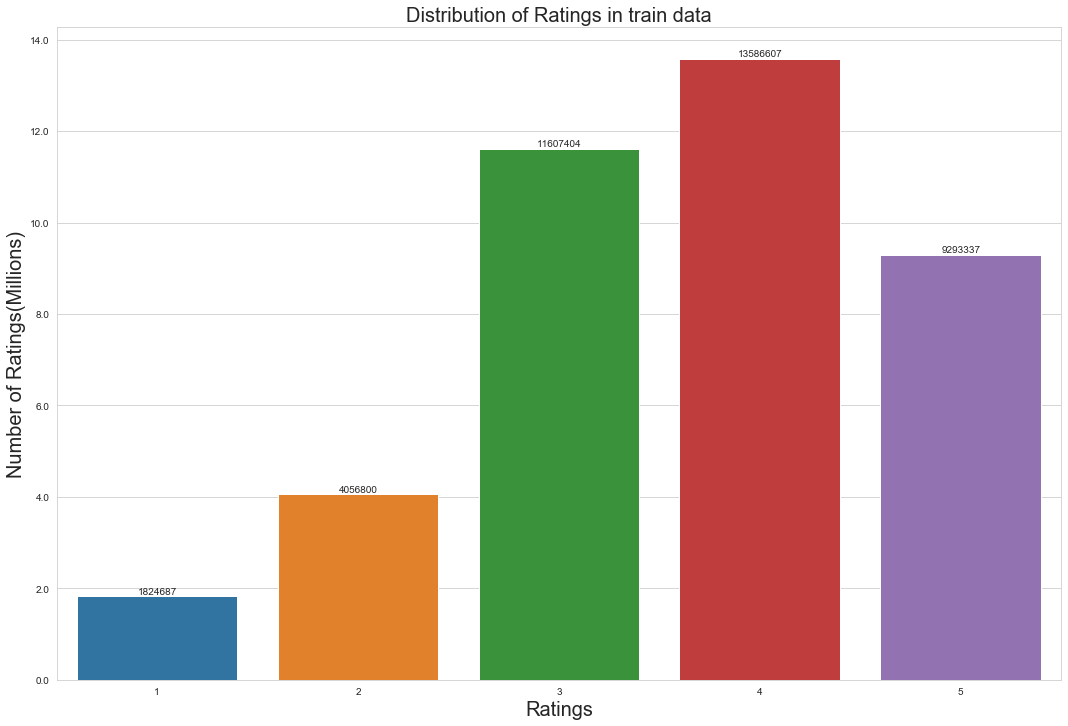

In [18]:
def changingLabels(number):
    return (number/10**6)

plt.figure(figsize = (18, 12))
count_plot = sns.countplot(x="Ratings", data=Train_Data)
for p in count_plot.patches:
    count_plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0,5),
                        textcoords = 'offset points')
count_plot.set_yticklabels([changingLabels(num) for num in count_plot.get_yticks()])

plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

# Analysis of Ratinng wrt Day of the Week

In [19]:
Train_Data["Day_Of_Week"] = Train_Data.Date.dt.weekday_name

In [20]:
Train_Data.head()

,MovieID,CustID,Ratings,Date,Day_Of_Week
0,5191,535765,2,2001-11-06,Tuesday
1,15129,533017,4,2004-12-20,Monday
2,6034,1178153,3,2005-01-31,Monday
3,14381,2083028,5,2004-10-26,Tuesday
4,14734,636881,4,2005-01-26,Wednesday


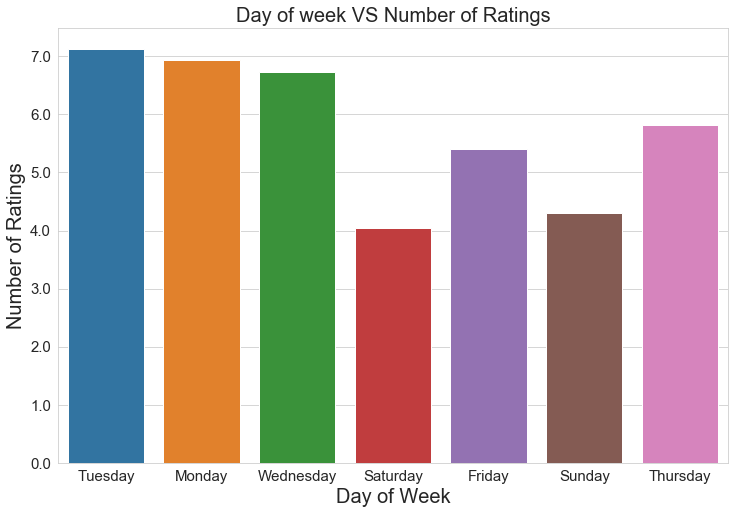

In [21]:
fig = plt.figure(figsize = (12, 8))

axes = sns.countplot(x = "Day_Of_Week", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.set_yticklabels([changingLabels(num) for num in axes.get_yticks()])
axes.tick_params(labelsize = 15)

plt.show()

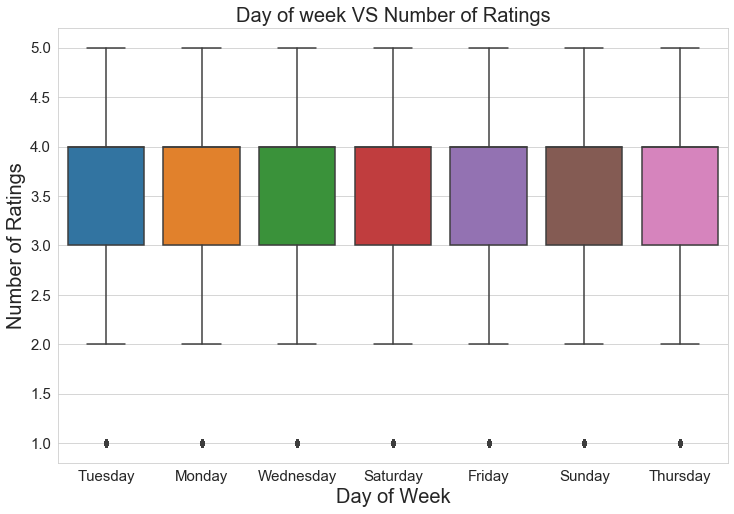

In [22]:
fig = plt.figure(figsize = (12, 8))

axes = sns.boxplot(x = "Day_Of_Week", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [23]:
average_ratings_dayofweek = Train_Data.groupby(by = "Day_Of_Week")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
Day_Of_Week
Friday       3.609840
Monday       3.598126
Saturday     3.618202
Sunday       3.619456
Thursday     3.605956
Tuesday      3.596242
Wednesday    3.606002
Name: Ratings, dtype: float64


### Distribution of ratings wrt month and year

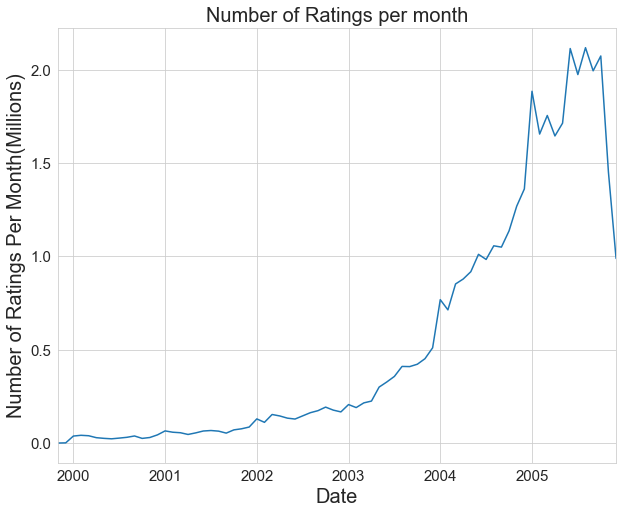

In [24]:
plt.figure(figsize = (10,8))
ax = Train_Data.resample("M", on = "Date")["Ratings"].count().plot()
ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])
ax.set_title("Number of Ratings per month", fontsize = 20)
ax.set_xlabel("Date", fontsize = 20)
ax.set_ylabel("Number of Ratings Per Month(Millions)", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.show()

#### Always better to visualize time using lines

# Analysis of Training Data Ratings given by user

In [25]:
Number_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [26]:
Number_of_rated_movies_per_user.head()

CustID
305344     6742
387418     6686
2439493    6389
1664010    6076
2118461    5682
Name: Ratings, dtype: int64

In [27]:
Number_of_rated_movies_per_user.tail()

CustID
2265873    1
1113824    1
1721133    1
2031108    1
587505     1
Name: Ratings, dtype: int64

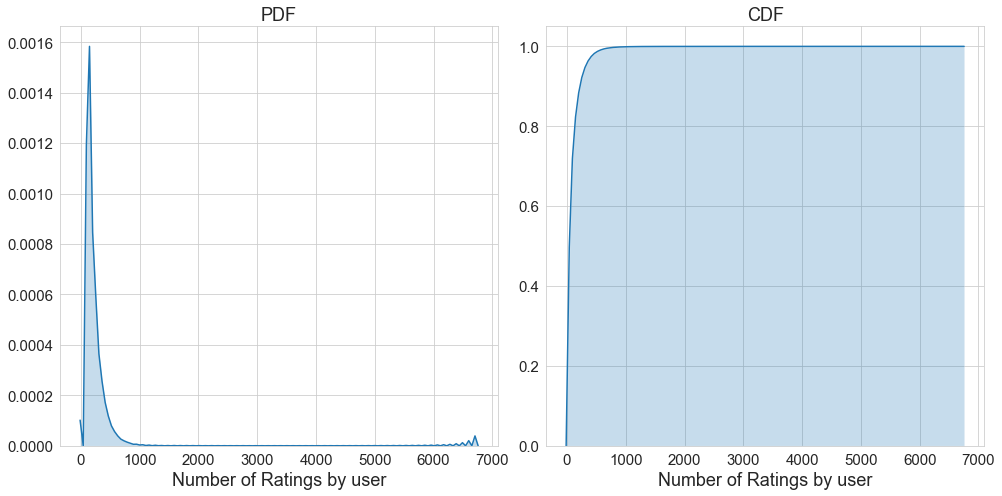

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))
sns.kdeplot(Number_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(Number_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

#### The above PDF and CDF plots conclude that most of the users rated very few movies and very less users rated many movies

In [29]:
print("Statistic movie ratings grouped by users:")
Number_of_rated_movies_per_user.describe()

Statistic movie ratings grouped by users:


count    477549.000000
mean         84.533388
std         120.594074
min           1.000000
25%          16.000000
50%          39.000000
75%         105.000000
max        6742.000000
Name: Ratings, dtype: float64

In [30]:
quantiles = Number_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01))


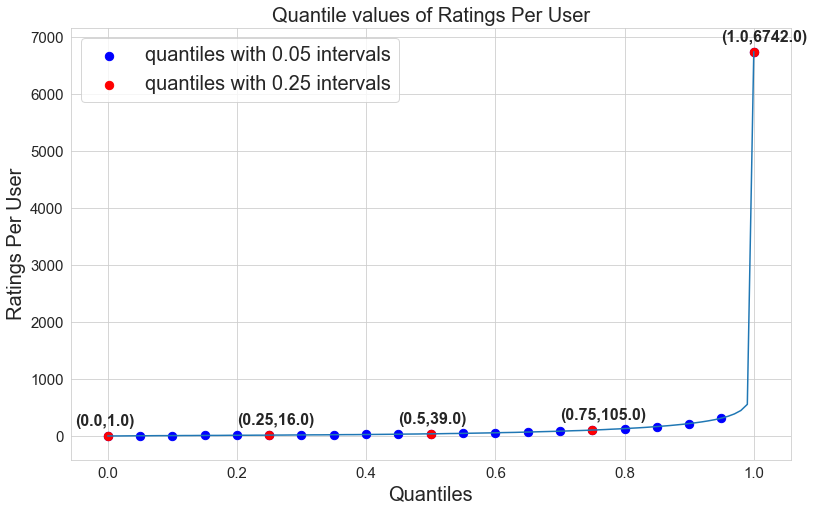

In [31]:
fig = plt.figure(figsize = (10, 6))

axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Quantile values of Ratings Per User", fontsize = 20)
axes.set_xlabel("Quantiles", fontsize = 20)
axes.set_ylabel("Ratings Per User", fontsize = 20)
axes.plot(quantiles)

plt.scatter(x = quantiles.index[::5], y = quantiles.values[::5], c = "blue", s = 70, label="quantiles with 0.05 intervals")
plt.scatter(x = quantiles.index[::25], y = quantiles.values[::25], c = "red", s = 70, label="quantiles with 0.25 intervals")
plt.legend(loc='upper left', fontsize = 20)

for x, y in zip(quantiles.index[::25], quantiles.values[::25]):
    plt.annotate(s = '({},{})'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 16, xytext=(x-0.05, y+180))
    
axes.tick_params(labelsize = 15)

In [32]:
quantiles[::5]

0.00       1.0
0.05       5.0
0.10       8.0
0.15      10.0
0.20      13.0
0.25      16.0
0.30      19.0
0.35      23.0
0.40      27.0
0.45      32.0
0.50      39.0
0.55      47.0
0.60      57.0
0.65      70.0
0.70      85.0
0.75     105.0
0.80     131.0
0.85     166.0
0.90     219.0
0.95     314.0
1.00    6742.0
Name: Ratings, dtype: float64

In [33]:
print("Total number of ratings below 75th percentile = ",sum(Number_of_rated_movies_per_user.values<=133))
print("Total number of ratings above 75th percentile = ",sum(Number_of_rated_movies_per_user.values>133))

Total number of ratings below 75th percentile =  384249
Total number of ratings above 75th percentile =  93300


### Analysis of Ratings Per Movie

In [34]:
Number_of_rated_movies_per_Movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

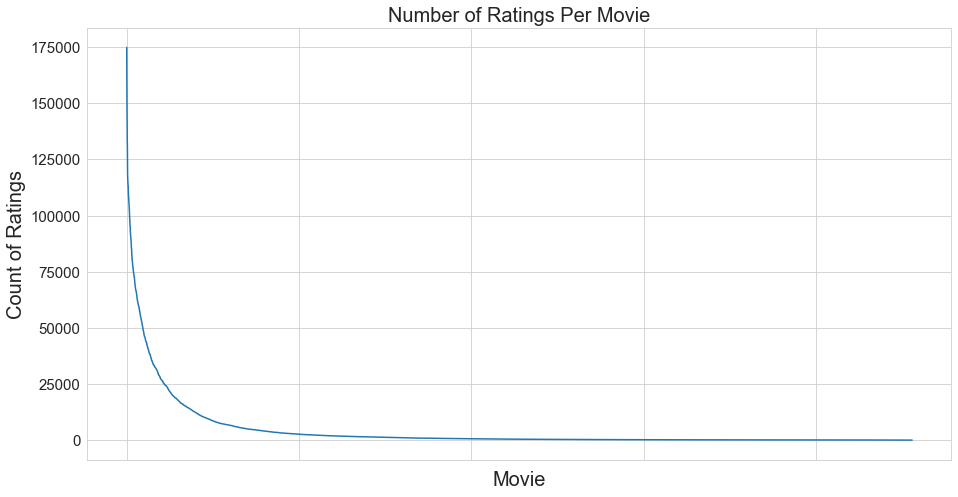

In [35]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(Number_of_rated_movies_per_Movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

<b>It is very skewed</b>
<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

# 3. Creating USER-ITEM sparse matrix from data frame

In [36]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for train Data")
if os.path.isfile("./Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    Train_UI_SparseData = sparse.load_npz("./Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = ",Train_UI_SparseData.shape)
    
else:
    print("We are creating sparse data")
    Train_UI_SparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    print("Creation done. Shape of sparse matrix = ",Train_UI_SparseData.shape)
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TrainUISparseData.npz", Train_UI_SparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix =  (2649430, 17771)
0:00:02.022365


In [37]:
startTime = datetime.now()
print("Creating USER_ITEM sparse matrix for test Data")
if os.path.isfile("./Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    Test_UI_SparseData = sparse.load_npz("./Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(Test_UI_SparseData.shape))
else:
    print("We are creating sparse data")
    Test_UI_SparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    print(Test_UI_SparseData)
    print("Creation done. Shape of sparse matrix = "+str(Test_UI_SparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("./Data/TestUISparseData.npz", Test_UI_SparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix = (2649430, 17771)
0:00:00.610996


In [38]:
#If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [39]:
rows,cols = Train_UI_SparseData.shape
non_zero_elements = Train_UI_SparseData.count_nonzero()

print("Sparsity Of Train matrix :  ",(1-(non_zero_elements/(rows*cols)))*100)

Sparsity Of Train matrix :   99.91426031179482


In [40]:
rows,cols = Test_UI_SparseData.shape
non_zero_elements = Test_UI_SparseData.count_nonzero()

print("Sparsity Of Test matrix : ",(1-(non_zero_elements/(rows*cols)))*100)

Sparsity Of Test matrix :  99.97142010251568


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [41]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sum_Of_Ratings = sparseMatrix.sum(axis = ax).A1 #this gives an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    no_Of_Ratings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sum_Of_Ratings[i]/no_Of_Ratings[i] for i in range(rows if if_user else cols) if no_Of_Ratings[i]!=0}
    return averageRatings

### Global Average Rating

In [42]:
Global_Average_Rating = Train_UI_SparseData.sum()/Train_UI_SparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.606089004054737


### Average Rating Per User

In [43]:
Avg_Rating_User = getAverageRatings(Train_UI_SparseData, True)

In [44]:
print("Average rating of user 25 = {}".format(Avg_Rating_User[25]))

Average rating of user 25 = 3.5833333333333335


### Average Rating Per Movie

In [45]:
Avg_Rating_Movie = getAverageRatings(Train_UI_SparseData, False)

In [46]:
print("Average rating of movie 4500 = {}".format(Avg_Rating_Movie[4500]))

Average rating of movie 4500 = 3.3399014778325125


### PDF and CDF of Average Ratings of Users and Movies

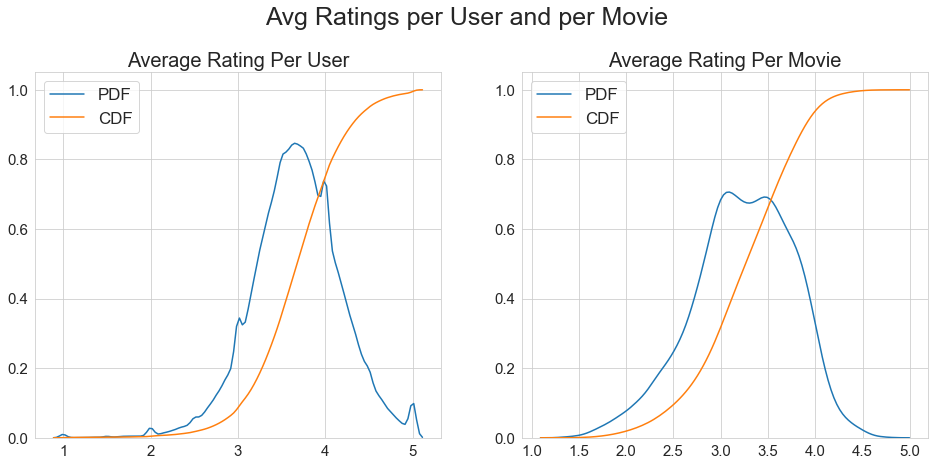

In [47]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rat for rat in Avg_Rating_User.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in Avg_Rating_Movie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem

#### Cold Start Problem with Users

In [48]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(Avg_Rating_User)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = ",total_users)
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users =  478723
Number of Users in train data= 477549
Number of Users not present in train data = 1174(0.0%)


#### Cold Start Problem with Movies

In [49]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(Avg_Rating_Movie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 9114
Number of Movies in train data= 9114
Number of Movies not present in train data = 0(0.0%)


# 4. Computing Similarity Matrices

### Computing User-User Similarity Matrix

Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_)

In [50]:
row_index, col_index = Train_UI_SparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
8
10
25
33
42
59
79
83
87
94
97
116
126
130
131
133
134
142
149
158
164
168
169
177
178
183
188
189
192
195
199
201
215
231
242
247
248
250
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
358
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
466
470
471
477
478
479
481
485
490
491
492
495
508
515
517
527
529
536
540


In [51]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(61700).reshape(617,100) 
    print(similarMatrix)# 617*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar users.
    time_Taken = []
    HowManyDone = 0
    for row in rows[:top]:
        HowManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        time_Taken.append(timeforOne)
        if HowManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(HowManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = {} Sec".format(sum(time_Taken)/len(time_Taken)))
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(time_Taken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(time_Taken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Time elapsed for 20 users = 0:00:39.479888sec
Time elapsed for 40 users = 0:01:12.850031sec
Time elapsed for 60 users = 0:01:45.192026sec
Time elapsed for 80 users = 0:02:19.576264sec
Time elapsed for 100 users = 0:02:52.515503sec
Average Time taken to compute similarity matrix for 1 user = 1.708995795249939 Sec


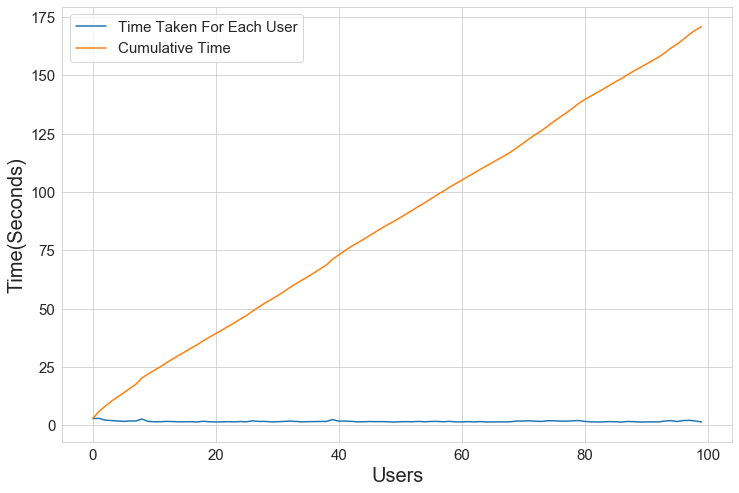

In [52]:
simMatrix = getUser_UserSimilarity(Train_UI_SparseData, 100)

###### Having 401901  Users in Training Data, The average time taken to compute similarity matrix would be 401901*3.635 =1460910.135sec = 405.808hours = 17Days
###### Computation of user-user similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.


### Computing Movie-Movie Similarity Matrix

In [53]:
Train_UI_SparseData.T

<17771x2649430 sparse matrix of type '<class 'numpy.int64'>'
	with 40368835 stored elements in Compressed Sparse Column format>

In [54]:
start = datetime.now()

if not os.path.isfile("./Data/m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(Train_UI_SparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz("./Data/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("./Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (17771, 17771)
0:00:05.757677


### Checking if Movie Movie Similarity works
### Let's pick random movie and check it's top 10 most similar movies.

In [55]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [56]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [57]:
movie_titles_df = pd.read_csv("./Data/movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")


In [58]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Similar Movies to: __Godzilla's Revenge__

In [60]:
movieID_rn = 17764

print("Name of the movie -------> ",(movie_titles_df.loc[movieID_rn][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_rn][1], Train_UI_SparseData[:,movieID_rn].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_rn][1], m_m_similarity[movieID_rn].count_nonzero()))

Name of the movie ------->  Shakespeare in Love
Number of ratings by users for movie Shakespeare in Love is 48742
Number of similar movies to Shakespeare in Love is 9114


In [61]:
# Meaning of "[:,17765]" means get all the values of column "17765".
# "getnnz()" give count of explicitly-stored values (nonzeros).

In [62]:

all_similar = sorted(m_m_similarity[movieID_rn].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

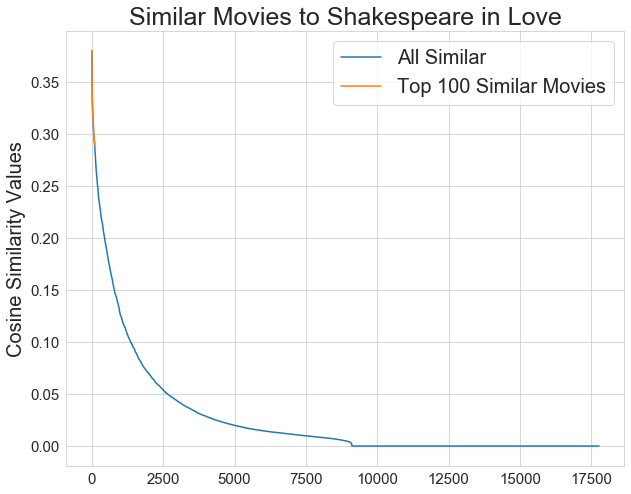

In [63]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Shakespeare in Love", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

### Top 10 Similar Movies to: Shakespeare in Love

In [64]:
movie_titles_df.loc[similar_movies_dict[movieID_rn][:10]]

,Year_of_Release,Movie_Title
MovieID,,
16452,2000.0,Chocolat
8904,1997.0,Good Will Hunting
15058,1999.0,Notting Hill
7193,1987.0,The Princess Bride
13763,1996.0,Jerry Maguire
14928,1989.0,Dead Poets Society
15758,1984.0,Amadeus
6206,2002.0,My Big Fat Greek Wedding
16272,2000.0,Crouching Tiger


## 5. Machine Learning Models

In [65]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = ",sparse_sample.shape)
    

    print(datetime.now() - start)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [66]:
path = "./Data/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649060, 17758)


### Creating Sample Sparse Matrix for Test Data

In [67]:
path = "./Data/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (2647200, 17747)


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [68]:
print("Global average of all movies ratings in Train Sample Sparse is ",np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2))

Global average of all movies ratings in Train Sample Sparse is  3.54


### Average of all movie ratings 

In [69]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
globalAvgMovies[7065]
#you can find global average of each movie based on their ID

2.5

###  Average rating of User

In [70]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
globalAvgUsers[344591]
#you can find global average of each User based on their ID

1.0

### Featurizing data

In [71]:
print("No of ratings in Our Sampled train matrix is : ",train_sample_sparse.count_nonzero())
print("No of ratings in Our Sampled test matrix is :",test_sample_sparse.count_nonzero())

No of ratings in Our Sampled train matrix is :  11150
No of ratings in Our Sampled test matrix is : 1430


### Featurizing data for regression problem

### Featurizing Train Data

In [72]:
sparse.find(train_sample_sparse)

(array([ 306640,  783642, 1615850, ..., 1694695, 2227822, 1700635],
       dtype=int32),
 array([ 4541,  4541,  4541, ..., 17738, 17738, 17757], dtype=int32),
 array([1, 2, 4, ..., 4, 3, 5]))

In [73]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [74]:
if os.path.isfile("./Data/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("./Data/Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  
            row.append(movie) 
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
            
 
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            

            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [75]:
Train_Reg = pd.read_csv("./Data/Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,306640,4541,3.538296,4.0,1.0,3.0,2.0,2.2,4.0,1.0,4.0,4.0,2.0,2.666667,2.2,1
1,783642,4541,3.538296,3.0,1.0,4.0,1.0,2.2,3.0,2.5,2.5,2.5,2.5,2.500000,2.2,2
2,1615850,4541,3.538296,1.0,1.0,2.0,3.0,2.2,2.0,1.0,4.0,2.0,5.0,3.358974,2.2,4
3,1871813,4541,3.538296,2.0,4.0,1.0,1.0,2.2,3.0,3.0,3.0,3.0,3.0,3.000000,2.2,3
4,2239213,4541,3.538296,4.0,2.0,1.0,3.0,2.2,2.0,1.0,1.0,5.0,2.0,2.413793,2.2,1


In [76]:
print("Number of nan Values = ",Train_Reg.isnull().sum().sum())

Number of nan Values =  0


<p><b>User_ID:</b> ID of a this User</p>

<p><b>Movie_ID:</b> ID of a this Movie</p>

<p><b>Global_Average:</b> Global Average Rating</p>

<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
   
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>

<p><b>User_Average:</b> Average Rating of this User</p>

<p><b>Movie_Average:</b> Average Rating of this Movie</p>

<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [77]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (11150, 16)


### Featurizing Test Data

In [78]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [79]:
if os.path.isfile("./Data/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("./Data/Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  
            row.append(movie) 
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating


            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #Ratings given by "user" to top 5 similar movies with "movie"
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                

            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#Converting rows and appending them as comma separated values to csv file
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [80]:
Test_Reg = pd.read_csv("./Data/Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,148395,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,5
1,294040,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3
2,630153,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3
3,692399,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4
4,925414,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4


In [81]:

print("Number of nan Values = ",Test_Reg.isnull().sum().sum())

Number of nan Values =  0


<p><b>User_ID:</b> ID of a this User</p>



<p><b>Movie_ID:</b> ID of a this Movie</p>



<p><b>Global_Average:</b> Global Average Rating</p>



<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>

    
    
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>


<p><b>User_Average:</b> Average Rating of this User</p>


<p><b>Movie_Average:</b> Average Rating of this Movie</p>


<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [82]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1430, 16)


### Transforming Data for Surprise Models

#### Transforming Train Data

- We can't give raw data (movie, user, rating) to train the model in Surprise library.
- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.
- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [83]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,306640,4541,1
1,783642,4541,2
2,1615850,4541,4
3,1871813,4541,3
4,2239213,4541,1


In [84]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

- For test data we just have to define a tuple (user, item, rating).
- You can check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812
- Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line
  177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods).
- "def build_testset(self)" method returns a list of tuples of (user, item, rating).

In [85]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [86]:
testset[:5]

[(148395, 4524, 5),
 (294040, 4524, 3),
 (630153, 4524, 3),
 (692399, 4524, 4),
 (925414, 4524, 4)]

### Applying Machine Learning Models

<p>We have two Error Metrics.</p>
 RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.
MAPE: Mean Absolute Percentage Error: </b>The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.</p>
<p>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>

<b>We can also use other regression models. But  we are using exclusively XGBoost as it is typically fairly powerful in practice.</b>

In [87]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [88]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Utility Functions for Regression Models

In [89]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [90]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [91]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Utility Functions for Surprise Models

In [92]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary as shown below:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [93]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [94]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
## Evaluating Train Data:
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
##Evaluating Test Data
    print("TEST DATA")
    test_pred = algo.test(testset)
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = {}".format(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

## 1. XGBoost 13 Features

--------------------------------------------------
TRAIN DATA
RMSE = 0.44905117246258214
MAPE = 11.464767808942733
--------------------------------------------------
TEST DATA
RMSE = 1.1344394361918
MAPE = 33.42763253191986
--------------------------------------------------
Time Taken = 0:00:01.114018


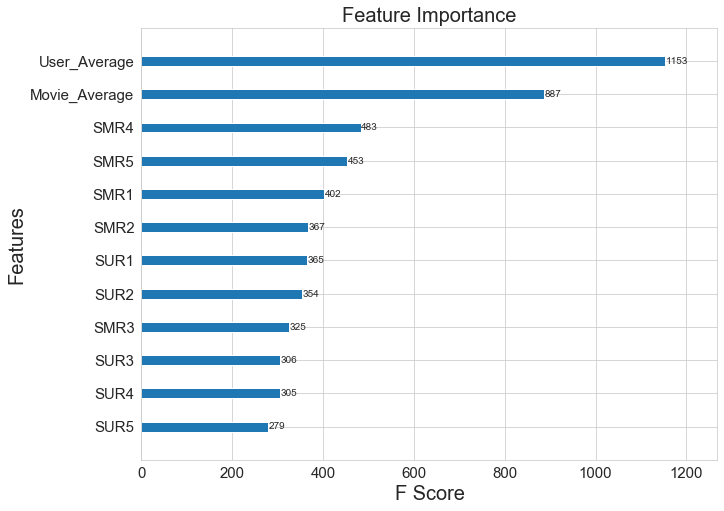

In [95]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

## 2. Surprise BaselineOnly Model

In [96]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8635467025151325
MAPE = 27.069324328859434
--------------------------------------------------
TEST DATA
RMSE = 1.0801518755848618
MAPE = 36.46892445494116
--------------------------------------------------
Time Taken = 0:00:00.191505


## 3. XGBoost 13 Features + Surprise BaselineOnly Model

### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [97]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]

In [98]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,306640,4541,3.538296,4.0,1.0,3.0,2.0,2.2,4.0,1.0,4.0,4.0,2.0,2.666667,2.2,1,2.265743
1,783642,4541,3.538296,3.0,1.0,4.0,1.0,2.2,3.0,2.5,2.5,2.5,2.5,2.500000,2.2,2,2.944127
2,1615850,4541,3.538296,1.0,1.0,2.0,3.0,2.2,2.0,1.0,4.0,2.0,5.0,3.358974,2.2,4,3.029621
3,1871813,4541,3.538296,2.0,4.0,1.0,1.0,2.2,3.0,3.0,3.0,3.0,3.0,3.000000,2.2,3,2.805236
4,2239213,4541,3.538296,4.0,2.0,1.0,3.0,2.2,2.0,1.0,1.0,5.0,2.0,2.413793,2.2,1,2.493320


In [99]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [100]:
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,148395,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,5,3.538296
1,294040,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3,3.538296
2,630153,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3,3.538296
3,692399,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4,3.538296
4,925414,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4,3.538296


In [101]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


--------------------------------------------------
TRAIN DATA
RMSE = 0.45093754330584923
MAPE = 11.707296954355982
--------------------------------------------------
TEST DATA
RMSE = 1.1804434046758367
MAPE = 32.61921383256388
--------------------------------------------------
Time Taken = 0:00:01.280183


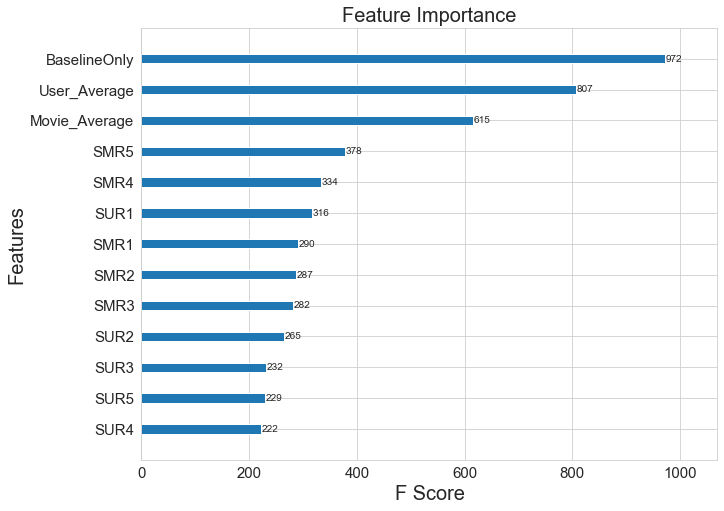

In [102]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

## 4. Surprise KNN-Baseline with User-User and Item-Item Similarity

### 4.1 Surprise KNN-Baseline with User-User.

#### Cross- Validation

In [103]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### Applying KNNBaseline User-User with best parameters

In [104]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.17544338126847875
MAPE = 4.362591960174013
--------------------------------------------------
TEST DATA
RMSE = 1.0799813900588981
MAPE = 36.476768167886235
--------------------------------------------------
Time Taken = 0:00:03.129046


### 4.2 Surprise KNN-Baseline with Item-Item.

#### Cross- Validation

In [105]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### Applying KNNBaseline Item-Item with best parameters

In [106]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.12754668795827448
MAPE = 2.7194574562763734
--------------------------------------------------
TEST DATA
RMSE = 1.0799813900588981
MAPE = 36.476768167886235
--------------------------------------------------
Time Taken = 0:00:00.355386


## 5. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline

### Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe

In [107]:
model_train_evaluation

{'XGBoost_13': {'RMSE': 0.44905117246258214,
  'MAPE': 11.464767808942733,
  'Prediction': array([1.0514522, 2.0114982, 3.899351 , ..., 3.4180222, 3.288149 ,
         4.9991503], dtype=float32)},
 'BaselineOnly': {'RMSE': 0.8635467025151325,
  'MAPE': 27.069324328859434,
  'Prediction': array([2.2657435 , 2.94412688, 3.02962098, ..., 3.40990627, 2.96266276,
         3.84699528])},
 'XGB_BSL': {'RMSE': 0.45093754330584923,
  'MAPE': 11.707296954355982,
  'Prediction': array([0.8090759, 1.9675037, 3.7959986, ..., 3.316735 , 3.4418845,
         5.002981 ], dtype=float32)},
 'KNNBaseline_User': {'RMSE': 0.17544338126847875,
  'MAPE': 4.362591960174013,
  'Prediction': array([1.0339025 , 2.1548633 , 3.99489433, ..., 5.        , 3.        ,
         5.        ])},
 'KNNBaseline_Item': {'RMSE': 0.12754668795827448,
  'MAPE': 2.7194574562763734,
  'Prediction': array([1.01317716, 1.98500257, 3.97527364, ..., 5.        , 3.        ,
         5.        ])}}

In [108]:
Train_Reg["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

Test_Reg["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [109]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,306640,4541,3.538296,4.0,1.0,3.0,2.0,2.2,4.0,1.0,4.0,4.0,2.0,2.666667,2.2,1,2.265743,1.033903,1.013177
1,783642,4541,3.538296,3.0,1.0,4.0,1.0,2.2,3.0,2.5,2.5,2.5,2.5,2.500000,2.2,2,2.944127,2.154863,1.985003
2,1615850,4541,3.538296,1.0,1.0,2.0,3.0,2.2,2.0,1.0,4.0,2.0,5.0,3.358974,2.2,4,3.029621,3.994894,3.975274
3,1871813,4541,3.538296,2.0,4.0,1.0,1.0,2.2,3.0,3.0,3.0,3.0,3.0,3.000000,2.2,3,2.805236,3.740326,3.727355
4,2239213,4541,3.538296,4.0,2.0,1.0,3.0,2.2,2.0,1.0,1.0,5.0,2.0,2.413793,2.2,1,2.493320,1.991238,1.998106


In [110]:
print("Number of nan values in Train Data",(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [111]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,148395,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,5,3.538296,3.538296,3.538296
1,294040,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3,3.538296,3.538296,3.538296
2,630153,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3,3.538296,3.538296,3.538296
3,692399,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4,3.538296,3.538296,3.538296
4,925414,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,4,3.538296,3.538296,3.538296


In [112]:
print("Number of nan values in Test Data ",(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data  0


--------------------------------------------------
TRAIN DATA
RMSE = 0.438969544256071
MAPE = 11.477409217674873
--------------------------------------------------
TEST DATA
RMSE = 1.1208446346512042
MAPE = 33.99490797853105
--------------------------------------------------
Time Taken = 0:00:01.278436


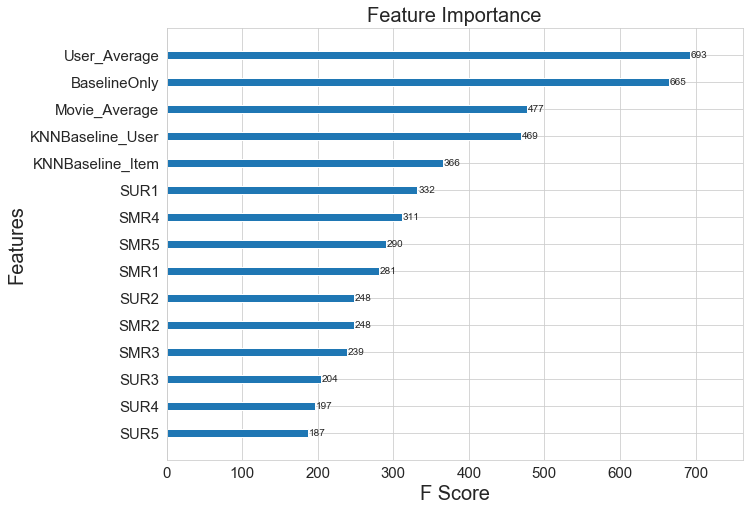

In [113]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

## 6. Matrix Factorization SVD 

#### Cross- Validation

In [114]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   #here, n_factors is the equivalent to dimension 'd' when matrix 'A'
#is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3,refit=True)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.012176571060291
{'n_factors': 5}


### Applying SVD with best parameters

In [115]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.894938885346847
MAPE = 28.613957161625947
--------------------------------------------------
TEST DATA
RMSE = 1.0800100139504276
MAPE = 36.477609566181016
--------------------------------------------------
Time Taken = 0:00:00.252909


## 7. Matrix Factorization SVDpp with implicit feedback

#### Cross- Validation

In [116]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.009902477129536
{'n_factors': 10, 'lr_all': 0.006}


#### Applying SVDpp with best parameters

In [117]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8078985435422532
MAPE = 25.55174585247003
--------------------------------------------------
TEST DATA
RMSE = 1.079811660640851
MAPE = 36.4650876207265
--------------------------------------------------
Time Taken = 0:00:02.832411


## 8. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [118]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [119]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,306640,4541,3.538296,4.0,1.0,3.0,2.0,2.2,4.0,1.0,...,4.0,2.0,2.666667,2.2,1,2.265743,1.033903,1.013177,2.664332,2.543471
1,783642,4541,3.538296,3.0,1.0,4.0,1.0,2.2,3.0,2.5,...,2.5,2.5,2.500000,2.2,2,2.944127,2.154863,1.985003,3.091318,3.071842
2,1615850,4541,3.538296,1.0,1.0,2.0,3.0,2.2,2.0,1.0,...,2.0,5.0,3.358974,2.2,4,3.029621,3.994894,3.975274,3.152245,3.297551
3,1871813,4541,3.538296,2.0,4.0,1.0,1.0,2.2,3.0,3.0,...,3.0,3.0,3.000000,2.2,3,2.805236,3.740326,3.727355,2.967371,3.052031
4,2239213,4541,3.538296,4.0,2.0,1.0,3.0,2.2,2.0,1.0,...,5.0,2.0,2.413793,2.2,1,2.493320,1.991238,1.998106,2.802012,2.694502


In [129]:
print("Number of nan values in Train Data ",(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data  0


In [121]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,148395,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,...,3.538296,3.538296,3.538296,3.538296,5,3.538296,3.538296,3.538296,3.538296,3.538296
1,294040,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,...,3.538296,3.538296,3.538296,3.538296,3,3.538296,3.538296,3.538296,3.538296,3.538296
2,630153,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,...,3.538296,3.538296,3.538296,3.538296,3,3.538296,3.538296,3.538296,3.538296,3.538296
3,692399,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,...,3.538296,3.538296,3.538296,3.538296,4,3.538296,3.538296,3.538296,3.538296,3.538296
4,925414,4524,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,3.538296,...,3.538296,3.538296,3.538296,3.538296,4,3.538296,3.538296,3.538296,3.538296,3.538296


In [128]:
print("Number of nan values in Test Data ",(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data  0


--------------------------------------------------
TRAIN DATA
RMSE = 0.4307010355823096
MAPE = 11.355646308904628
--------------------------------------------------
TEST DATA
RMSE = 1.1237156588906156
MAPE = 34.0256421390948
--------------------------------------------------
Time Taken = 0:00:01.547536


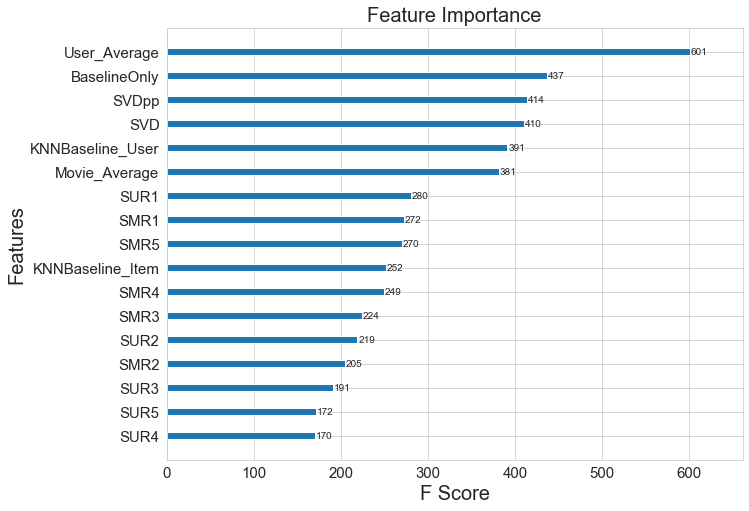

In [123]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

## 9. Surprise KNN Baseline + SVD + SVDpp

--------------------------------------------------
TRAIN DATA
RMSE = 0.840687053215081
MAPE = 26.700133082150362
--------------------------------------------------
TEST DATA
RMSE = 1.084661138327163
MAPE = 36.67832023891818
--------------------------------------------------
Time Taken = 0:00:00.657629


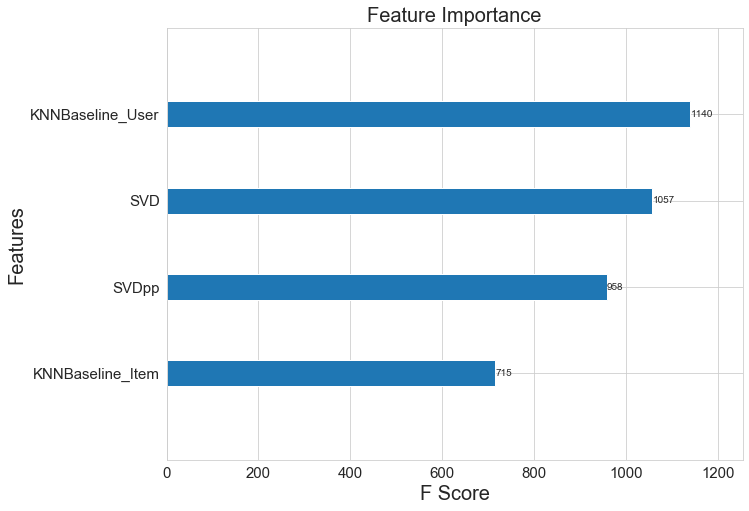

In [124]:
x_train = Train_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

x_test = Test_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF")

model_train_evaluation["XGB_KNN_MF"] = train_result
model_test_evaluation["XGB_KNN_MF"] = test_result

## Summary

In [125]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

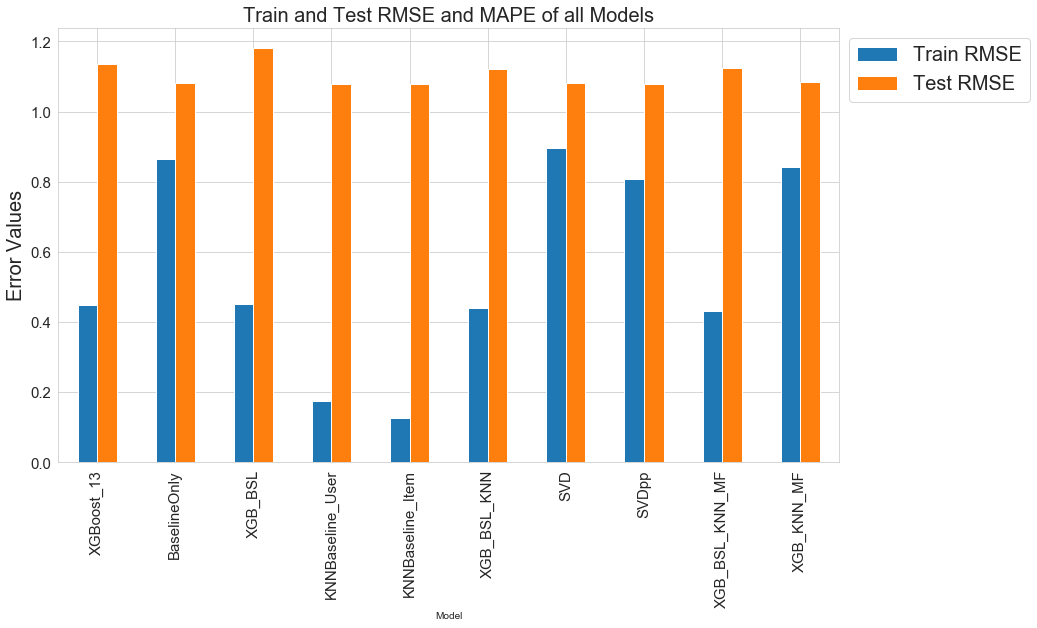

In [126]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [127]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.449051,1.13444
1,BaselineOnly,0.863547,1.08015
2,XGB_BSL,0.450938,1.18044
3,KNNBaseline_User,0.175443,1.07998
4,KNNBaseline_Item,0.127547,1.07998
5,XGB_BSL_KNN,0.43897,1.12084
6,SVD,0.894939,1.08001
7,SVDpp,0.807899,1.07981
8,XGB_BSL_KNN_MF,0.430701,1.12372
9,XGB_KNN_MF,0.840687,1.08466


# So, far our best model is SVDpp with Test RMSE of 1.07981